# TSIA202a - Third Practice Session

The goal of this third partical work is to use an AR(p) process to model a speech signal, and show that this approch is surprisingly powerful despite its simplicity.

The proposed synthesis algorithm divides into several steps.
1. Filter the audio signal to emphasize the highest frequencies (in order to flatten the spectrum and reduce precision issues with FFT computations).
2. Split the signal into several overlapping frames and iterate over them.
    1. Detect if the frame corresponds to noise or to a voiced signal, and estimate the fundamental frequency in the later case.
    2. Estimate the AR(p) coefficients using Yule-Walker equations.
    3. Re-synthetise the frame using the AR(p) coefficients, starting from a white noise in the case of a noisy frame, or a Dirac comb in the case of a voiced frame.
3. Overlap-add the synthesized frames with a Hanning window.
4. Filter the synthesised signal to de-emphasize the highest frequencies.

We propose to implement this algorithm in two parts. First, we will derive the Yule-Walker equations, and test them on synthetic data. Then, we will code the synthesis algorithm and apply it on a real world speech signal.


# 1. Yule-Walker equations

Let us consider a causal, zero-mean, AR(p) process defined by the following recurrent equation: 
$$
X_t = \phi_1 X_{t-1} + \phi_2 X_{t-2} + \ldots + \phi_p X_{t-p} + Z_t
$$
where $\{Z_t , t \in \mathbb{Z}\}$ is a weak white noise with variance $\sigma^2$.

1. Show that, $\forall h \geq 1, \mathbb{E}[X_{t-h}Z_t]=0$.
2. Deduce a recurrent relation between $\gamma(h)$ and $\gamma(h-1),\gamma(h-2),\ldots,\gamma(h-p)$, for $h \geq 1$.
3. We consider separately the case $h=0$: find a new relationship between $\gamma(0)$ and $\gamma(-1),\gamma(-2),\ldots,\gamma(-p)$.
4. Put these relationships in matrix form:
\begin{equation}
\Gamma_{p+1}[1 \; -\phi_1 \; \ldots \; -\phi_p]^T = [\sigma_2 \; 0 \; \ldots \; 0]^T 
\end{equation}
where $\Gamma_{p+1}$ is a suitable Toeplitz matrix that you have to determine.

# 2. Evaluation on synthetic data

We will now evaluate equation $(1)$ on a synthetically generated AR(p) process.

1. Generate n=1000 samples of an AR(4) process.
2. Estimate $\Gamma_{p+1}$ using these samples.
3. Use equation $(1)$ to estimate $\sigma^2$ and the coefficients $\phi_1,\phi_2,\ldots,\phi_p$. Compute the relative error between the estimated and the true coefficients.
4. Estimate power spectral distribution of the synthesized signal. Compare with the theoretical distribution obtained from the poles of $1/\Phi(z^{-1})$.

# 3. Speech modeling

We will now implement the synthesis algorithm and evaluate it on a speech signal. 

A code template is provided below. We will use the file audio.wav to test the algorithm. 


LIsten to the original and synthesized signal by using any audio player. Try to modify the pitch of the synthesised signal and listen to the result.


In [5]:
## imports

import librosa
import soundfile as sf
import scipy
import numpy as np
import math
from collections import defaultdict
from tqdm import tqdm
import matplotlib.animation
import matplotlib.pyplot as plt
from IPython.display import HTML

In [6]:
## hyperparameters

sampling_rate = 8000 # (Hz)
frame_duration = 0.04 # duration of the analysis frames (seconds)
overlap_ratio = 0.5 # overlap ratio between two consecutive analysis frames
p = 12 # AR(p) model order
f_min = 80 # minimum frequency for pitch detection (Hz)
f_max = 400 # maximum frequency for pitch detection Hz)
pitch_detection_threshold = 0.5 # threshold for pitch detection

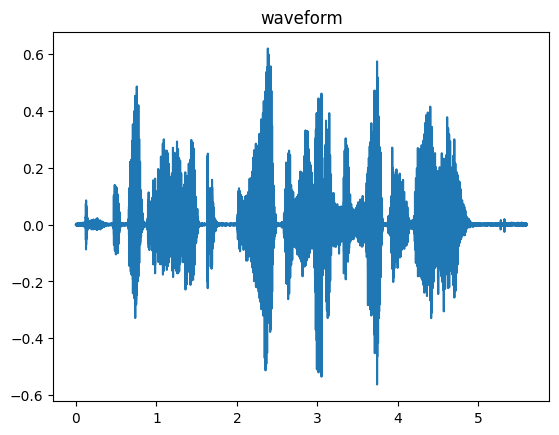

ValueError: x and y must have same first dimension, but have shapes (279,) and (0,)

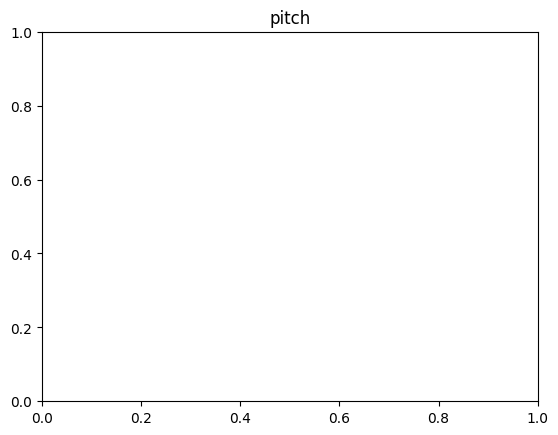

In [9]:
## plot

# time axis for plotting
sample_time = np.linspace(0, len(x)/sampling_rate, len(x))
frame_time = np.linspace(0, n_frame*frame_duration*(1-overlap_ratio), n_frame)

# waveform
plt.title("waveform")
plt.plot(sample_time, x)
plt.show()

# pitch
plt.title("pitch")
plt.plot(frame_time, log_dict["pitch"])
plt.show()

# variance
plt.title("sigma")
plt.plot(frame_time, log_dict["sigma"])
plt.show()

# power spectral density
fig, ax = plt.subplots()
fig.suptitle("estimated & theoretical spectral density")
y_min = min(log_dict["original_psd"].min(), log_dict["synthesis_psd"].min())
y_max = max(log_dict["original_psd"].max(), log_dict["synthesis_psd"].max())
def animate(i):
    ax.cla()
    ax.set_ylim([y_min-0.1, y_max+0.1])
    ax.plot(log_dict["original_psd"][i], label="original_psd")
    ax.plot(log_dict["synthesis_psd"][i], label="synthesis_psd")
animation = matplotlib.animation.FuncAnimation(fig, animate, frames=len(log_dict["original_psd"]))
display(HTML(animation.to_jshtml()))
plt.close()

# 1. Yule-Walker equations

Let us consider a causal, zero-mean, AR(p) process defined by the following recurrent equation: 
$$
X_t = \phi_1 X_{t-1} + \phi_2 X_{t-2} + \ldots + \phi_p X_{t-p} + Z_t
$$
where $\{Z_t , t \in \mathbb{Z}\}$ is a weak white noise with variance $\sigma^2$.

1. Show that, $\forall h \geq 1, \mathbb{E}[X_{t-h}Z_t]=0$.
2. Deduce a recurrent relation between $\gamma(h)$ and $\gamma(h-1),\gamma(h-2),\ldots,\gamma(h-p)$, for $h \geq 1$.
3. We consider separately the case $h=0$: find a new relationship between $\gamma(0)$ and $\gamma(-1),\gamma(-2),\ldots,\gamma(-p)$.
4. Put these relationships in matrix form:
\begin{equation}
\Gamma_{p+1}[1 \; -\phi_1 \; \ldots \; -\phi_p]^T = [\sigma_2^2 \; 0 \; \ldots \; 0]^T 
\end{equation}
where $\Gamma_{p+1}$ is a suitable Toeplitz matrix that you have to determine.

#### **Question 1**

Par linéarité on a :  

\begin{align*} 
\mathbb{E}[X_{t-h}Z_t] &= \sum _{i=1}^p \mathbb{E}(\phi_t X_{t-h-i} Z_t )+ \; \mathbb{E}(Z_t Z_{t-h}) \quad Z_t \; \text{est indépendant de } X_{t-h-i} \, \text{ si } h\geq 1 \quad \text{d'où}\\
&= \sum _{i=1}^p \mathbb{E}(\phi_t X_{t-h-i}) \mathbb{E}(Z_t)+ \; \mathbb{E}(Z_t Z_{t-h}) 
\end{align*}
On a $\mathbb{E}(Z_t Z_{t-h})=0 $ si $ h \geq 1$ donc  
\begin{align*} 
\mathbb{E}[X_{t-h}Z_t] &= \sum _{i=1}^p \phi_t\mathbb{E}( X_{t-h-i}) \mathbb{E}(Z_t) \quad \text{et on sait que  } \; \mathbb{E}(Z_t) =0 \\
&=0
\end{align*}

#### **Question 2**

On a   
  
\begin{align*}
\gamma(h)&= Cov(X_t,X_{t-h})\\
&= Cov(\phi_1 X_{t-1} + \phi_2 X_{t-2} + \ldots + \phi_p X_{t-p} + Z_t, X_{t-h})\\
&= Cov(\phi_1 X_{t-1},X_{t-h}) +Cov(\phi_2 X_{t-2},X_{t-h}) +  \ldots +Cov(\phi_p X_{t-p},X_{t-h})  + Cov(Z_t, X_{t-h})\\
&= \sum _{i=1}^p \phi_p \gamma_(h-p) + \mathbb{E}(( Z_t - \mathbb{E}(Z_t)) \cdot (X_{t-h}-\mathbb{E}(X_{t-h})))\\
\end{align*}

Or on a  
$\mathbb{E}(( Z_t - \mathbb{E}(Z_t)) \cdot (X_{t-h}-\mathbb{E}(X_{t-h}))) =\mathbb{E}(Z_t \cdot (X_{t-h}-\mathbb{E}(X_{t-h}))) = \mathbb{E}(Z_t X_{t-h})-\mathbb{E}(Z_t)\mathbb{E}(X_{t-h}) = 0 \quad $ d'après la question précédente

*Finalement*,

$\gamma(h)=\sum _{i=1}^p \phi_p \gamma_(h-p)$

#### **Question 3**

Si h=0, On  a   

\begin{align*}  
\gamma(0)&= Cov(X_t,X_t)\\
&=Cov(\phi_1 X_{t-1} + \phi_2 X_{t-2} + \ldots + \phi_p X_{t-p} + Z_t, X_t)\\
&= \phi_1Cov( X_{t-1},X_t)+ \phi_2Cov(X_{t-2}, X_t) + \ldots + \phi_pCov (X_{t-p},X_t)+ Cov(Z_t, X_t)\\
&=\sum_{i=1}^p \phi_i\gamma(i) + \sigma^2\\
&=\sum_{i=1}^p \phi_i\gamma(-i) + \sigma^2
\end{align*}

##### **Question 4**

La matrice de Toeplitz des covariances pour un processus AR(p) est donnée par :

\begin{equation}
\Gamma_{p+1} = \begin{bmatrix}
  \gamma(0) & \gamma(-1) & \gamma(-2) & \cdots & \gamma(-p)\\
  \gamma(1) & \gamma(0) & \gamma(1) & \cdots & \gamma(1-p) \\
  \gamma(2) & \gamma(1) & \gamma(0) & \cdots & \gamma(2-p) \\
  \vdots & \vdots & \vdots & \ddots & \vdots \\
  \gamma(p) & \gamma(p-1) & \gamma(p-2) & \cdots & \gamma(0)
\end{bmatrix}
\end{equation}

# 2. Evaluation on synthetic data

We will now evaluate equation $(1)$ on a synthetically generated AR(p) process.

1. Generate n=1000 samples of an AR(4) process.
2. Estimate $\Gamma_{p+1}$ using these samples.
3. Use equation $(1)$ to estimate $\sigma^2$ and the coefficients $\phi_1,\phi_2,\ldots,\phi_p$. Compute the relative error between the estimated and the true coefficients.
4. Estimate power spectral distribution of the synthesized signal. Compare with the theoretical distribution obtained from the poles of $1/\Phi(z^{-1})$.

#### **Qestion 1**


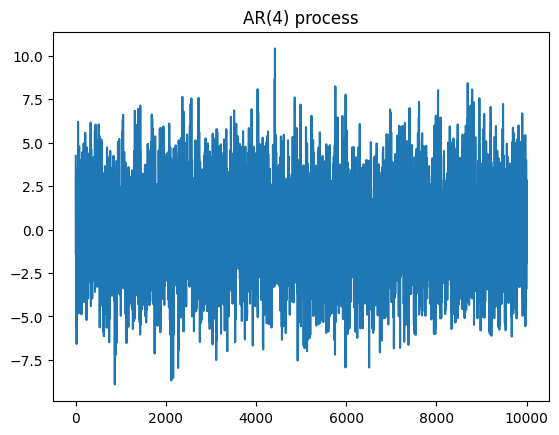

In [28]:
n=10000
sigma = 2
X=[np.random.normal(0,sigma) for i in range(4)]
for k in range(3,n):    
    phi1=0.1
    phi2=-0.2
    phi3=0.2
    phi4=0.5
    X.append(phi1*X[k-1]+phi2*X[k-2]+phi3*X[k-3]+phi4*X[k-4]+np.random.normal(0,sigma))

plt.plot(X)
plt.title("AR(4) process")
plt.show()


##### **Question 2**